In [1]:
import numpy as np
import bosonicplus

In [2]:
from bosonicplus.interferometers.symplectics import rotation
from bosonicplus.interferometers.ops import apply_symplectic
from bosonicplus.states.from_sf import prepare_cat_bosonic, prepare_gkp_bosonic
from bosonicplus.states.coherent import outer_coherent, eps_fock_coherent, eps_superpos_coherent
from bosonicplus.states.wigner import get_wigner_coherent
from strawberryfields.backends.states import BaseBosonicState
from bosonicplus.plotting import plot_wigner_marginals
import matplotlib.pyplot as plt
from scipy.special import factorial
import strawberryfields as sf

from strawberryfields.ops import Kgate, Coherent, Catstate, Rgate, GKP
from time import time

from bosonicplus.states.gkp_squeezing import gkp_nonlinear_squeezing_operator

#from bosonicplus.states.nongauss import 

In [3]:
class PureBosonicState:
    """Store a pure bosonic state as superposition of coherent states
    """
    def __init__(self, pure_data : tuple):
        """
        data = [alphas, coeffs]
        """
        self.pure_data = pure_data
        self.coeffs = pure_data[1]
        self.alphas = pure_data[0]
        self.num_alphas = len(self.alphas)

    def get_dm_form(self):
        means = []
        covs = np.eye(2)
        cs = self.coeffs
        weights = []

        for i in range(self.num_alphas):
            for j in range(self.num_alphas):
                
                mij, cov, cij = outer_coherent(self.alphas[i], self.alphas[j])
                weights.append(cs[i]*np.conjugate(cs[j])*cij)
                #weights[i,j] *= cij
                means.append(mij)
        
        self.data = np.array(means), covs, np.array(weights)/np.sum(weights)
        
    def get_fock_probs(self, cutoff = 10):
        ns = range(cutoff)
        ps = np.zeros(cutoff,dtype='complex')
        cs = self.coeffs
        a = self.alphas
        for n in ns: 
            
            for i in range(self.num_alphas):
                ps[n] += cs[i]* np.exp(-np.abs(a[i])**2/2) * a[i]**n/ np.sqrt(factorial(n))
                
        
        self.fock_probs = np.abs(ps)**2
        
def fock_coherent_pure(N, infid, eps = None):
    """Generate the pure state data for a Fock state N in the coherent state representation.
    
    Args:
        N (int): fock number
        infid (float): infidelity of approximation
        eps (float): coherent state amplitude, takes presidence over infid if specified.
        
    See Eq 28 of http://arxiv.org/abs/2305.17099 for expansion into coherent states.
    """
    
    alphas = []
    theta = 2*np.pi/(N+1)
    weights = []
    if not eps:
        eps = eps_fock_coherent(N, infid)
    
    for k in np.arange(N+1):

        alpha = eps * np.exp(1j * theta * k) 
        alphas.append(alpha)
        weights.append(np.exp(-theta*1j*N*k))

    #if N == 0:
     #   means = []
      #  means.append(np.array([0,0]))
        
            
    weights = np.array(weights)
    factor = np.sqrt(factorial(N))/(N+1) * np.exp(eps**2/2)/eps**N

    weights *= factor
    weights /= np.sqrt(np.sum(np.abs(weights)**2))
    
    return np.array(alphas), weights


def gkp_coherent_pure(n, type, infid=1e-4):
    rho = gkp_nonlinear_squeezing_operator(n, 1, type=type)

    w, v = np.linalg.eigh(rho)
    
    coeffs = v[:,0] #eigs always sorted from lowest to highest eigenvalue, choose lowest

    alphas, weights = fock_superpos_coherent(coeffs, infid)


    return alphas, weights
    
    
def prepare_coherent(alpha):
    weights = np.array([1])
    means = np.array([np.array([alpha.real, alpha.imag])])
    covs = np.array([np.eye(2)])
    return BaseBosonicState([means, covs, weights], 1, 1)

In [4]:
def fock_superpos_coherent(coeffs, infid, eps = None):
    """Returns the coherent state amplitudes and coefficeints of the state |psi> = c0 |0> + c1 |1> + c2 |2> + ... + c_max |n_max>
    in the coherent-fock representation.

    Args:
        coeff (list/array):  the coefficients in front of the number states, coeff = [c0, c1, c2, ... c_nmax] 
        infid (float): infidelity of approx
    Returns: 
        alphas (ndarray): list of amplitudes
        weights (ndarray): list of weights
    """
    def get_ck(k, N, coeffs, eps):
        """Get coefficient ck in Eq (22) in http://arxiv.org/abs/2305.17099 for a superposition of Fock states
    
        Args:
            k (int) : coefficient number
            N (int) : max Fock number in superposition
            coeffs (list/array) 
            eps (float) 
        Returns:
            ck (complex) : k'th coefficient
        """
        ck = 0
        for n, an in enumerate(coeffs):
            ck += np.exp(eps**2 / 2)/(N+1) * np.sqrt(factorial(n)*1.0) / eps**n * an * np.exp(-2*np.pi * 1j * n * k /(N+1))
            
        return ck
    
    weights = []
    alphas = []

    N = len(coeffs)-1
    
    weights = np.zeros(N+1, dtype = 'complex128')
    alphas = np.zeros(N+1,dtype='complex128')
    
    if not eps:
        eps = eps_superpos_coherent(N, infid)
        
    theta = 2*np.pi /(N+1) 
    #Obtain new weights
    for i in np.arange(N+1):
        weights[i] = get_ck(i,N,coeffs, eps)
        alphas[i] = eps*np.exp(1j*theta*i)
        
    return alphas, weights



In [5]:
def kerr_coeff(m, q): 
    """Eq. (13), (14) of https://journals.aps.org/pra/pdf/10.1103/PhysRevA.47.5024
    """
    ns = np.arange(m)
    
    if m % 2 == 1:
        return 1/m*np.exp(2*np.pi*1j*q/m * ns - 1j*np.pi/m*ns*(ns-1))
    elif m % 2 ==0: 
        return 1/m*np.exp(2*np.pi*1j*q/m * ns - 1j*np.pi/m*ns**2)

def kerr_exponents(m,q):
    ns = np.arange(m)
    
    if m % 2 == 1:
        return 2*np.pi*1j*q/m*ns - 1j*np.pi/m*ns*(ns-1)
    elif m % 2 ==0: 
        return 2*np.pi*1j*q/m*ns - 1j*np.pi/m*ns**2


def kerr_unitaries(m):
    """Eq. (16), (17) of https://journals.aps.org/pra/pdf/10.1103/PhysRevA.47.5024
    """
    qs = np.arange(m)
    
    weights = np.array([np.sum(kerr_coeff(m, q)) for q in qs])

    if m % 2 == 1: 
        thetas = 2*np.pi*qs/m
    elif m %2 == 0:
        thetas = 2*np.pi*qs/m + np.pi/m    
    return weights, thetas

def apply_kerr_gate(state, m):
    """
    state : PureBosonicState
    m : int
    """
    #kerr_weights = kerr_coeffs(m)
    kerr_weights, thetas =  kerr_unitaries(m)

    alphas, cs = state.pure_data
    print(alphas.shape, cs.shape)

    final_dim = len(kerr_weights) * len(cs)

    new_alphas = ((alphas[np.newaxis,:] * np.exp(-1j*thetas[:,np.newaxis]))).reshape([final_dim])

    new_cs = (cs[np.newaxis,:]*kerr_weights[:,np.newaxis]).reshape([final_dim])
    #new_weights /= np.sum(new_weights)
    print(new_alphas.shape, new_cs.shape)
    #norm = np.sqrt(np.sum(np.abs(new_cs)**2))

    out_state = PureBosonicState([new_alphas, new_cs])
    #print(np.sum(out_state.weights))
    return out_state


## Kerr interaction on a coherent state
$\hat{U}^{m}\ket{\alpha}$, where the unitary, $\hat{U}^{m}=e^{-i\frac{\pi}{m}\hat{n}(\hat{n}-1)}$, can be written as a linear combination of rotations according to Eq. (10-11), (13-14) of https://journals.aps.org/pra/pdf/10.1103/PhysRevA.47.5024

In strawberryfields, the Kerr gate is $\hat{U}=e^{-i\kappa \hat{n}^2}$, which is not exactly the same as the Kerr intreaction which is $\hat{H}=\kappa \hat{a}^\dagger\hat{a}^\dagger\hat{a}\hat{a}$.

In [6]:
#Some general settings
alpha = np.sqrt(10)
x = np.linspace(-8,8,200)
m = 4

In [7]:
#Bosonicplus method
t0 = time()

#Initialise a coherent state
data = [np.array([alpha]),np.array([1])]
state = PureBosonicState(data)

kerr_state = apply_kerr_gate(state, m)

kerr_state.get_dm_form()
means, covs, weights = kerr_state.data
print('norm: ', np.sum(weights))
print(means.shape, covs.shape, weights.shape)

W_bp = get_wigner_coherent(kerr_state, x,x)

tf = time()


print(f'Total time to do kerr gate and obtain wigner with bosonicplus: {tf-t0} s')

(1,) (1,)
(4,) (4,)
norm:  (1+0j)
(16, 2) (2, 2) (16,)
Total time to do kerr gate and obtain wigner with bosonicplus: 0.06509113311767578 s


[4.53999298e-05 4.53999298e-04 2.26999649e-03 7.56665496e-03
 1.89166374e-02 3.78332748e-02 6.30554580e-02 9.00792257e-02
 1.12599032e-01 1.25110036e-01 1.25110036e-01 1.13736396e-01
 9.47803301e-02 7.29079462e-02 5.20771044e-02 3.47180696e-02
 2.16987935e-02 1.27639962e-02 7.09110899e-03 3.73216263e-03]


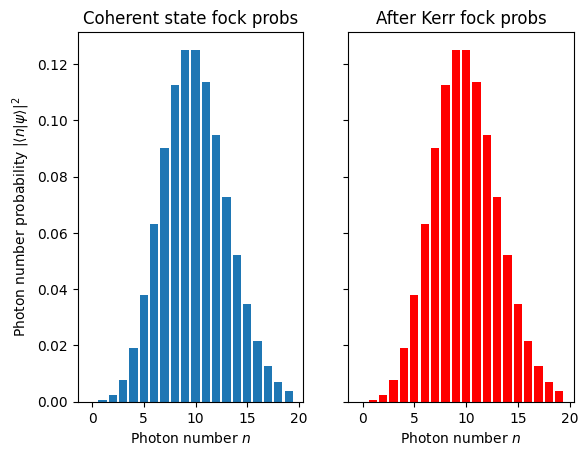

In [8]:
cutoff = 20
state.get_fock_probs(cutoff)
#state.fock_probs

kerr_state.get_fock_probs(cutoff)

print(kerr_state.fock_probs)
w = 1
fig, axes = plt.subplots(1,2,sharex=True,sharey=True)
axes[0].bar(np.arange(cutoff), state.fock_probs)
axes[0].set_title('Coherent state fock probs')
axes[0].set_ylabel(r'Photon number probability $|\langle n | \psi \rangle|^2$')
axes[0].set_xlabel(r'Photon number $n$')
axes[1].set_xlabel(r'Photon number $n$')
axes[1].bar(np.arange(cutoff), kerr_state.fock_probs,color='r')
axes[1].set_title('After Kerr fock probs')
plt.show()

In [9]:
#strawberryfields method
t0 = time()
eng = sf.Engine('fock', backend_options={"cutoff_dim": 20})
prog = sf.Program(1)

with prog.context as q:
    Coherent(alpha, np.pi/2) | q[0]
    Kgate(np.pi/m) | q[0]
result = eng.run(prog)
W_fock = result.state.wigner(0, x,x)

tf = time()

print(f'Total simulation time with strawberryfields {tf-t0}')

Total simulation time with strawberryfields 0.07492685317993164


/Users/s163967/venv/240827-bp/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/s163967/venv/240827-bp/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/plotting.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


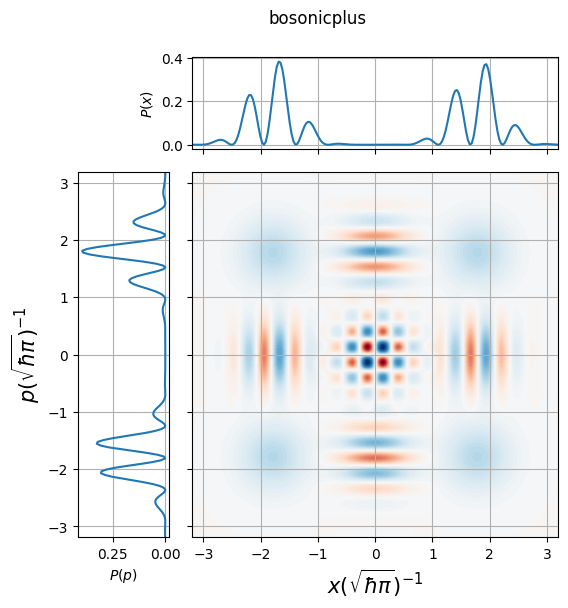

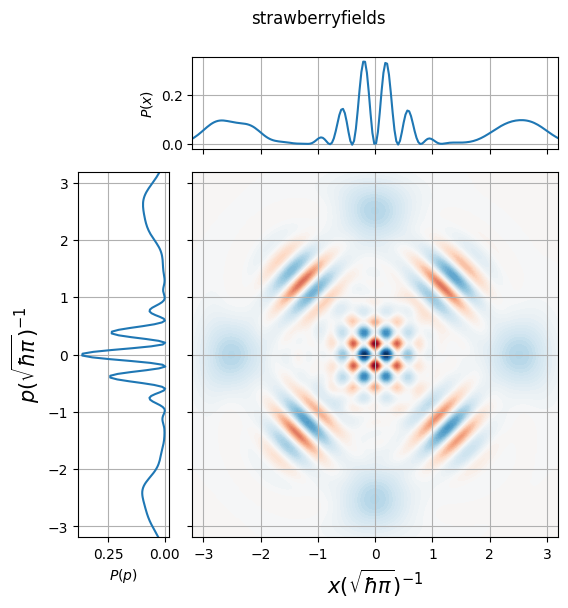

In [10]:
plot_wigner_marginals(W_bp,x,x,'bosonicplus')
plt.show()
plot_wigner_marginals(W_fock,x,x,'strawberryfields')
plt.show()

## Kerr interaction on cat states

(2,) (2,)
(16,) (16,)
norm:  (1+0j)
(256, 2) (2, 2) (256,)
0.41141510009765625


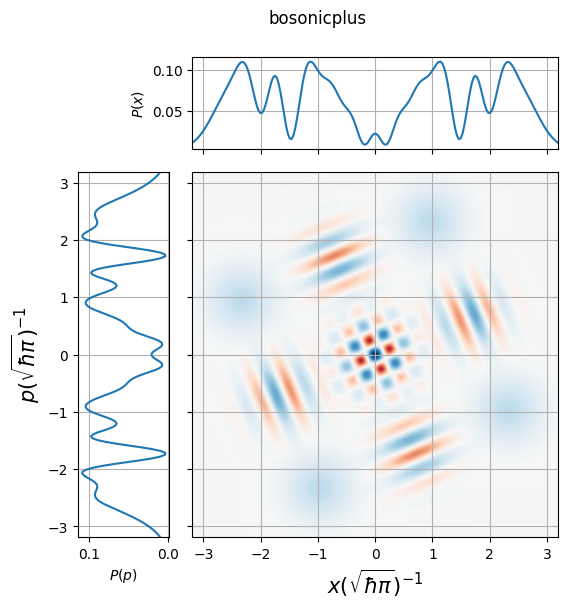

In [11]:
alpha = np.sqrt(10)
x = np.linspace(-8,8,200)
m = 8
t0 = time()
data = [np.array([alpha,-alpha]),1/np.sqrt(2)*np.array([1,1])]
state = PureBosonicState(data)

kerr_state = apply_kerr_gate(state, m)

kerr_state.get_dm_form()
means, covs, weights = kerr_state.data
print('norm: ', np.sum(weights))
print(means.shape, covs.shape, weights.shape)

W_bp = get_wigner_coherent(kerr_state, x,x)
tf = time()
print(tf-t0)
plot_wigner_marginals(W_bp,x,x,'bosonicplus')

plt.show()

[9.07998595e-05 0.00000000e+00 4.53999298e-03 0.00000000e+00
 3.78332748e-02 0.00000000e+00 1.26110916e-01 0.00000000e+00
 2.25198064e-01 0.00000000e+00 2.50220071e-01 0.00000000e+00
 1.89560660e-01 0.00000000e+00 1.04154209e-01 0.00000000e+00
 4.33975870e-02 0.00000000e+00 1.41822180e-02 0.00000000e+00]


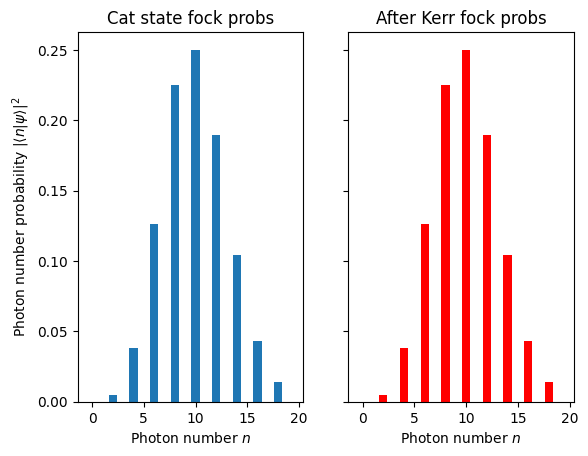

In [12]:
cutoff = 20
state.get_fock_probs(cutoff)
#state.fock_probs

kerr_state.get_fock_probs(cutoff)

print(kerr_state.fock_probs)
w = 1
fig, axes = plt.subplots(1,2,sharex=True,sharey=True)
axes[0].bar(np.arange(cutoff), state.fock_probs)
axes[0].set_title('Cat state fock probs')
axes[0].set_ylabel(r'Photon number probability $|\langle n | \psi \rangle|^2$')
axes[0].set_xlabel(r'Photon number $n$')
axes[1].set_xlabel(r'Photon number $n$')
axes[1].bar(np.arange(cutoff), kerr_state.fock_probs,color='r')
axes[1].set_title('After Kerr fock probs')
plt.show()

In [13]:
#strawberryfields method
t0 = time()
eng = sf.Engine('fock', backend_options={"cutoff_dim": 20})
prog = sf.Program(1)

with prog.context as q:
    Catstate(alpha, np.pi, 0) | q[0]
    Kgate(np.pi/m) | q[0]
    Rgate(-np.pi/m) | q[0]
result = eng.run(prog)
W_fock = result.state.wigner(0, x,x)

tf = time()

print(f'Total simulation time with strawberryfields {tf-t0}')

Total simulation time with strawberryfields 0.14080405235290527


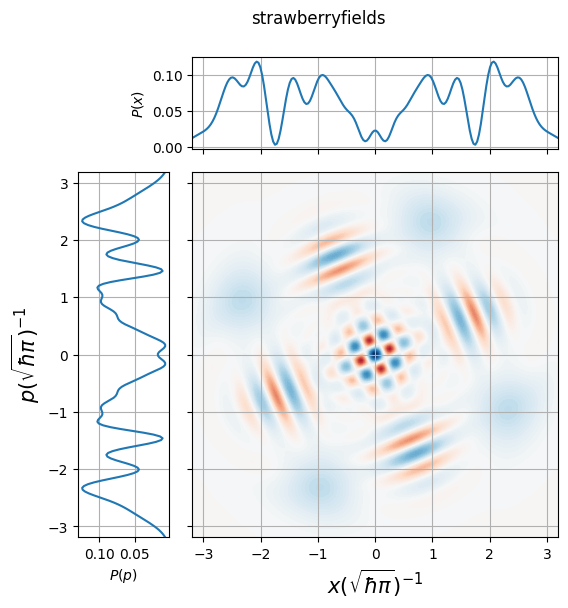

In [14]:
plot_wigner_marginals(W_fock,x,x,'strawberryfields')
plt.show()

## Kerr on GKP
OBS: The Fock expansion of the GKP state in strawberryfields is found in a different way than in bosonicplus, where we use the Petr Marek's GKP squeezing operator to find the best Fock expansion of a given GKP state.

In [36]:
cutoff = 20
t0 = time()
gkp_data = gkp_coherent_pure(cutoff, '0')
gkp = PureBosonicState(gkp_data)
tl = time()
print(f'GKP gen time {tl-t0}')
gkp.get_dm_form()

print('No of coherent states: ', len(gkp_data[1]))
print('No of Gaussians: ', len(gkp.data[2]))

m = 8

W = get_wigner_coherent(gkp, x,x)

ti = time()

kerr_state = apply_kerr_gate(gkp, m)
tj = time()
print(f'Kerr gate application time: {tj-ti}')

kerr_state.get_dm_form()
means, covs, weights = kerr_state.data
print('norm: ', np.sum(weights))
print(means.shape, covs.shape, weights.shape)

W_bp = get_wigner_coherent(kerr_state, x,x)
tf = time()
print(tf-t0)


GKP gen time 0.12799882888793945
No of coherent states:  21
No of Gaussians:  441
(21,) (21,)
(168,) (168,)
Kerr gate application time: 0.0002090930938720703
norm:  (0.9999999999999967-7.688294445529209e-15j)
(28224, 2) (2, 2) (28224,)
42.59947395324707


In [37]:
#strawberryfields method
t0 = time()
eng = sf.Engine('fock', backend_options={"cutoff_dim": cutoff})
prog = sf.Program(1)

with prog.context as q:
    GKP(state = [0,0], epsilon=0.1) | q[0]
    Kgate(np.pi/m) | q[0]
    #Rgate(-np.pi/m) | q[0]
result = eng.run(prog)
W_fock = result.state.wigner(0, x,x)
probs = result.state.all_fock_probs()

tf = time()

print(f'Total simulation time with strawberryfields {tf-t0}')

Total simulation time with strawberryfields 0.05331993103027344


/Users/s163967/venv/240827-bp/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/s163967/venv/240827-bp/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/bosonicplus/plotting.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


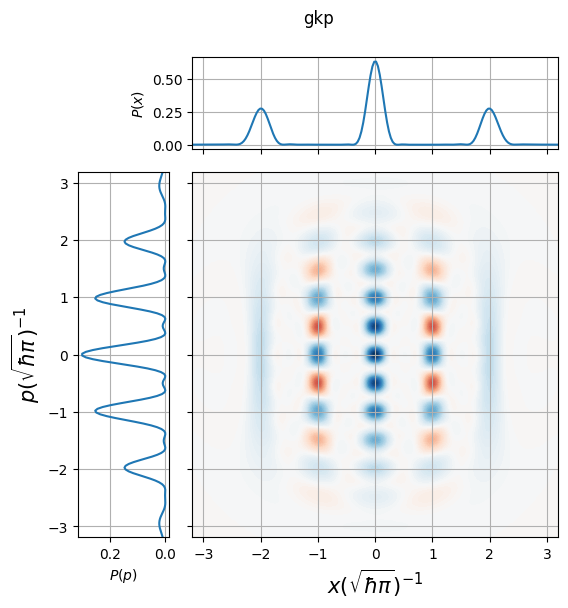

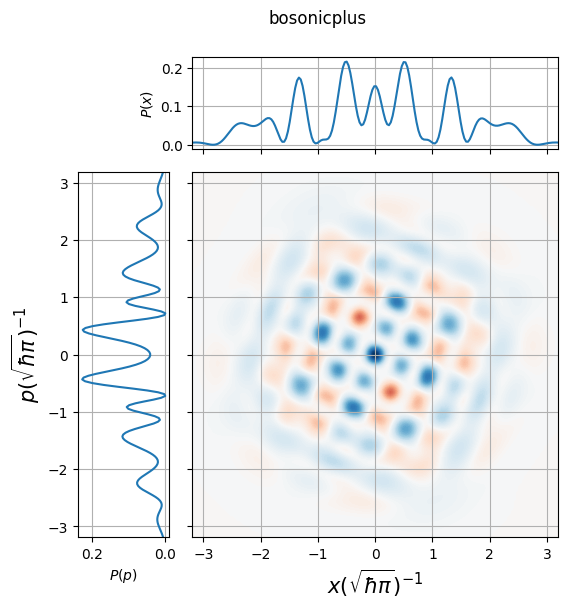

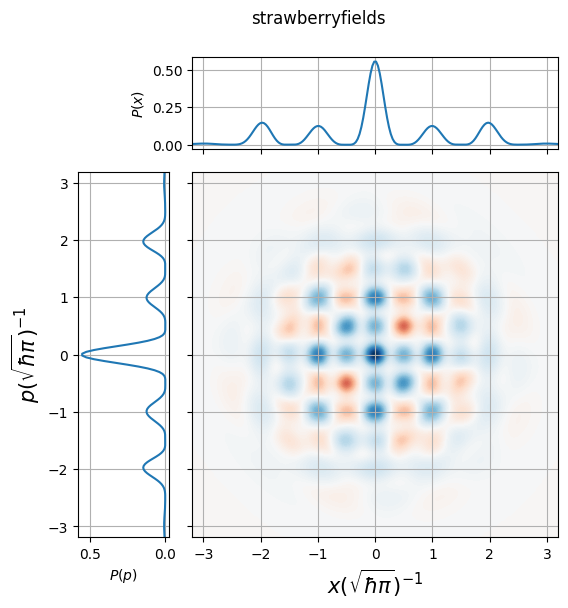

In [38]:
plot_wigner_marginals(W,x,x,'gkp')
plt.show()
plot_wigner_marginals(W_bp,x,x,'bosonicplus')
plt.show()
plot_wigner_marginals(W_fock,x,x,'strawberryfields')
plt.show()

0.9976620170013569
0.9976620170013585


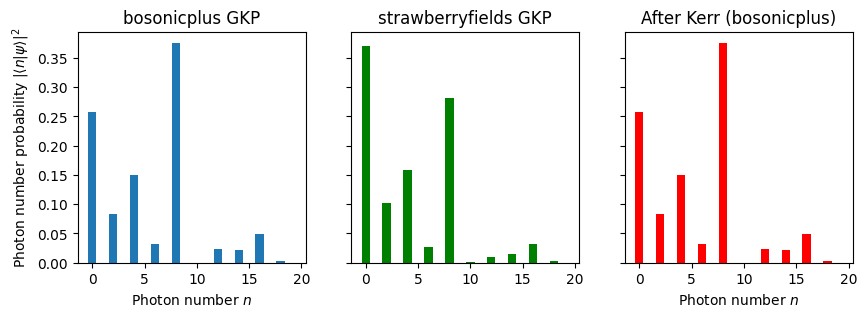

In [39]:
cutoff = 20
gkp.get_fock_probs(cutoff)
#state.fock_probs

kerr_state.get_fock_probs(cutoff)


print(np.sum(kerr_state.fock_probs))
print(np.sum(gkp.fock_probs))
w = 1
fig, axes = plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,3))
axes[0].bar(np.arange(cutoff), gkp.fock_probs)
axes[0].set_title('bosonicplus GKP')
axes[0].set_ylabel(r'Photon number probability $|\langle n | \psi \rangle|^2$')

axes[1].bar(np.arange(cutoff), probs,color='g')
axes[1].set_title('strawberryfields GKP')

axes[0].set_xlabel(r'Photon number $n$')
axes[2].set_xlabel(r'Photon number $n$')
axes[2].bar(np.arange(cutoff), kerr_state.fock_probs,color='r')
axes[2].set_title('After Kerr (bosonicplus)')
plt.show()